In [1]:
import time, os
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from utils.dataset import load_dataset_v2, create_lstm_dataset
from tqdm.notebook import tqdm

In [2]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))

start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [3]:
dataset= load_dataset_v2(file_path_list)

loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

In [4]:
dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

In [5]:
extra_column_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
extra_feature = pd.DataFrame()

for col_name in extra_column_name_list:
    extra_feature['grad_'+col_name] = np.gradient(dataset[col_name].to_numpy())

dataset = pd.concat([dataset, extra_feature], axis=1)

In [6]:
dataset_value = dataset.drop(columns=['reserved', 'time(s)', 'test_case', 'test_case_iter'])
dataset_value = pd.concat([dataset_value, extra_feature], axis=1)

In [18]:
feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)', 'grad_pressure_1(bar)', 'grad_main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_feature = train_data[feature_col_name_list]
train_feature.reset_index(drop=True, inplace=True)

train_target = pd.DataFrame(train_data[target_col_name])
train_target.reset_index(drop=True, inplace=True)

val_feature = val_data[feature_col_name_list]
val_feature.reset_index(drop=True, inplace=True)

val_target = pd.DataFrame(val_data[target_col_name])
val_target.reset_index(drop=True, inplace=True)

In [20]:
seq_len = 30
pred_distance = 0

train_feature_lstm, train_target = create_lstm_dataset(train_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
val_feature_lstm, val_target = create_lstm_dataset(val_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)

In [9]:
best_lstm_model = keras.models.load_model('lstm_model.keras')

In [21]:
train_pred = np.squeeze(best_lstm_model.predict(train_feature_lstm, verbose=1))
val_pred = np.squeeze(best_lstm_model.predict(val_feature_lstm, verbose=1))

2000/2000 [==============================] - 7s 4ms/step


In [17]:
np.mean(np.abs(train_target-train_pred)/train_target*100)

16.17923914543519

In [22]:
np.mean(np.abs(val_target-val_pred)/val_target*100)

22.301637589250927

In [28]:
val_data_2 = val_data.copy()
val_data_2 = val_data_2[29:]
val_data_2['abs_error'] = np.abs(val_target-val_pred)
val_data_2['relative_error'] = (np.abs(val_target-val_pred)/val_target)*100

In [37]:
val_data_2 = val_data_2[['nozzle_dia(mm)', 'nozzle_len(mm)', 'venturi_dist(mm)', 'pump_speed(rpm)', 'outlet_flowrate(lpm)', 'abs_error', 'relative_error']]

<Axes: >

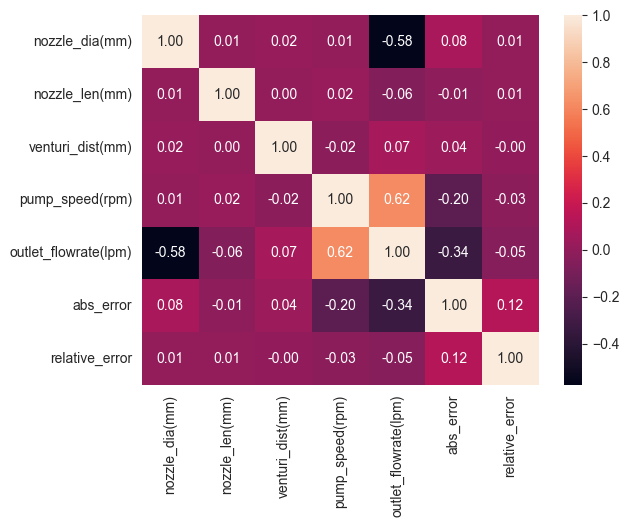

In [38]:
sns.heatmap(val_data_2.corr(), annot=True, fmt='.2f')

<Axes: xlabel='outlet_flowrate(lpm)', ylabel='abs_error'>

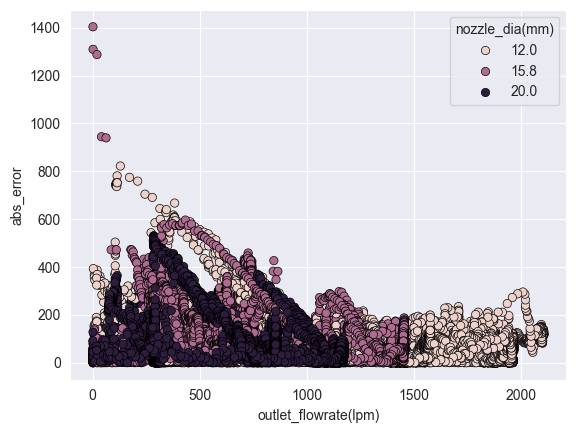

In [39]:
sns.scatterplot(data=val_data_2, x='outlet_flowrate(lpm)', y='abs_error', hue='nozzle_dia(mm)', edgecolor='black')

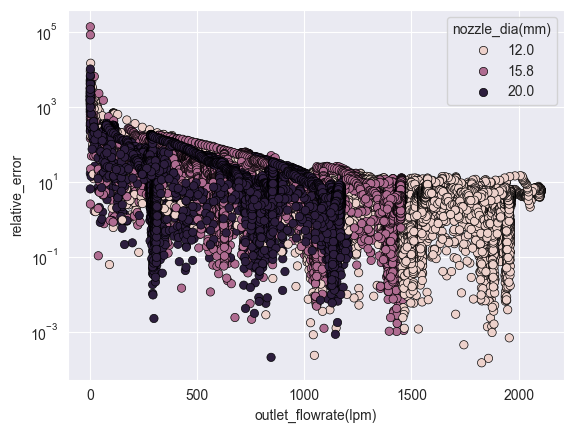

In [40]:
sns.scatterplot(data=val_data_2, x='outlet_flowrate(lpm)', y='relative_error', hue='nozzle_dia(mm)', edgecolor='black')
plt.yscale('log')